In [3]:
!pip install gym imageio

Defaulting to user installation because normal site-packages is not writeable


Episode 0, Total Reward: 13.0
Episode 10, Total Reward: 13.0
Episode 20, Total Reward: 19.0
Episode 30, Total Reward: 28.0
Episode 40, Total Reward: 32.0
Episode 50, Total Reward: 8.0
Episode 60, Total Reward: 39.0
Episode 70, Total Reward: 15.0
Episode 80, Total Reward: 21.0
Episode 90, Total Reward: 38.0
Episode 100, Total Reward: 47.0
Episode 110, Total Reward: 32.0
Episode 120, Total Reward: 13.0
Episode 130, Total Reward: 61.0
Episode 140, Total Reward: 58.0
Episode 150, Total Reward: 70.0
Episode 160, Total Reward: 37.0
Episode 170, Total Reward: 42.0
Episode 180, Total Reward: 15.0
Episode 190, Total Reward: 32.0
Episode 200, Total Reward: 55.0
Episode 210, Total Reward: 72.0
Episode 220, Total Reward: 23.0
Episode 230, Total Reward: 126.0
Episode 240, Total Reward: 51.0
Episode 250, Total Reward: 24.0
Episode 260, Total Reward: 81.0
Episode 270, Total Reward: 124.0
Episode 280, Total Reward: 117.0
Episode 290, Total Reward: 30.0


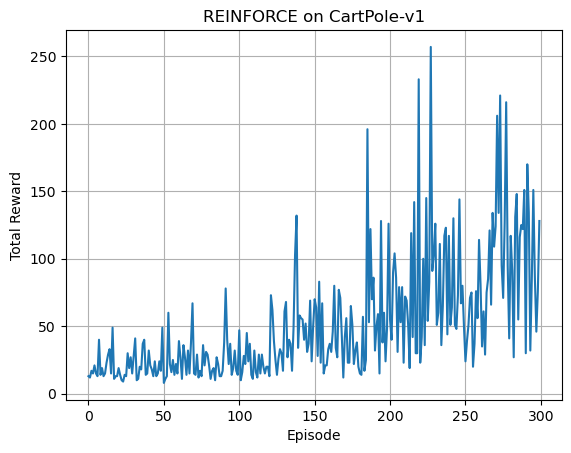

C:\Users\chirkova_aa\AppData\Roaming\Python\Python312\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at C:\Users\chirkova_aa\agent_video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building video C:\Users\chirkova_aa\agent_video\rl-video-episode-0.mp4.
MoviePy - Writing video C:\Users\chirkova_aa\agent_video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\chirkova_aa\agent_video\rl-video-episode-0.mp4
Test Episode Total Reward: 108.0


GIF сохранён: agent_performance.gif


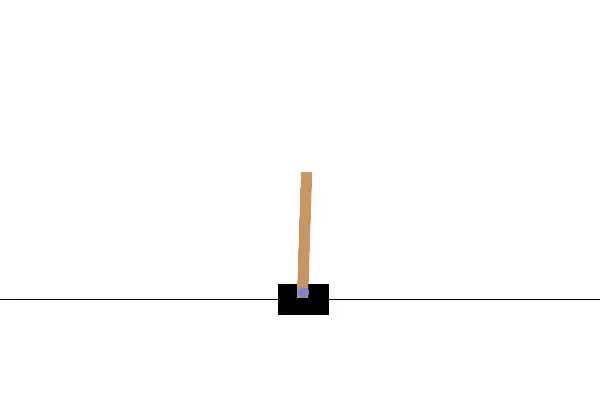

In [10]:
# Импорты
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import imageio
import os


# Фиксируем seed
torch.manual_seed(42)
np.random.seed(42)


# Создаем среду
env = gym.make('CartPole-v1', render_mode='rgb_array')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n


# --- Архитектура политики ---
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        assert input_dim == 4, f"Expected input_dim=4, got {input_dim}"
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)


# --- REINFORCE агент ---
class REINFORCEAgent:
    def __init__(self, state_dim, action_dim):
        self.policy = PolicyNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-3)

    def get_action(self, state):
        if not isinstance(state, np.ndarray):
            state = np.array(state)
        state = state.ravel()
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        probs = self.policy(state_tensor)
        dist = Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def update(self, rewards, log_probs, gamma=0.99):
        discounted_rewards = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            discounted_rewards.insert(0, R)

        # Нормализуем награды
        discounted_rewards = torch.tensor(discounted_rewards)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-7)

        policy_loss = []
        for log_prob, reward in zip(log_probs, discounted_rewards):
            policy_loss.append(-log_prob * reward)

        self.optimizer.zero_grad()
        torch.stack(policy_loss).sum().backward()
        self.optimizer.step()


# --- Обучение ---
def train_reinforce(episodes=300):
    agent = REINFORCEAgent(state_dim, action_dim)
    scores = []

    for episode in range(episodes):
        state = env.reset()[0]
        done = False
        total_reward = 0
        log_probs = []
        rewards = []

        while not done:
            action, log_prob = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            rewards.append(reward)
            log_probs.append(log_prob)
            state = next_state
            total_reward += reward

        agent.update(rewards, log_probs)
        scores.append(total_reward)

        if episode % 10 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")

    return scores, agent


# --- Визуализация результатов ---
def plot_scores(scores):
    plt.plot(scores)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("REINFORCE on CartPole-v1")
    plt.grid(True)
    plt.show()


# --- Тестирование с визуализацией ---
def test_agent_with_video(agent, video_folder="agent_video"):
    global env  # используем глобальную env
    try:
        env.close()
    except:
        pass

    # Пересоздаём среду с нужным рендер-модом
    env = gym.make('CartPole-v1', render_mode='rgb_array')

    # Создаем папку для видео
    if not os.path.exists(video_folder):
        os.makedirs(video_folder)

    # Оборачиваем среду для записи видео
    env = gym.wrappers.RecordVideo(env, video_folder)

    # Тестируем агента
    state = env.reset()[0]
    done = False
    total_reward = 0

    while not done:
        action, _ = agent.get_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = next_state
        total_reward += reward

    print(f"Test Episode Total Reward: {total_reward}")
    env.close()

    # Конвертируем видео в GIF
    convert_video_to_gif(video_folder)


# --- Преобразование видео в GIF ---
def convert_video_to_gif(video_folder):
    import glob

    # Находим последнее записанное видео
    video_files = sorted(glob.glob(os.path.join(video_folder, "*.mp4")))
    if not video_files:
        print("Видео не найдено.")
        return

    video_path = video_files[-1]

    # Считываем кадры
    reader = imageio.get_reader(video_path)
    frames = [frame for frame in reader]

    # Сохраняем как GIF
    gif_path = "agent_performance.gif"
    imageio.mimsave(gif_path, frames, duration=1/reader.get_meta_data()['fps'])
    print(f"GIF сохранён: {gif_path}")

    # Отображаем в Jupyter
    from IPython.display import Image, display
    display(Image(filename=gif_path))


# --- Запуск обучения ---
scores, agent = train_reinforce(episodes=300)
plot_scores(scores)


# --- Тестирование с визуализацией ---
test_agent_with_video(agent)